<a href="https://colab.research.google.com/github/MaxwellPaparelli/Machine_Learning/blob/main/Deep_Learning_Classif_Roupas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Roupas utilizando Deep Learning

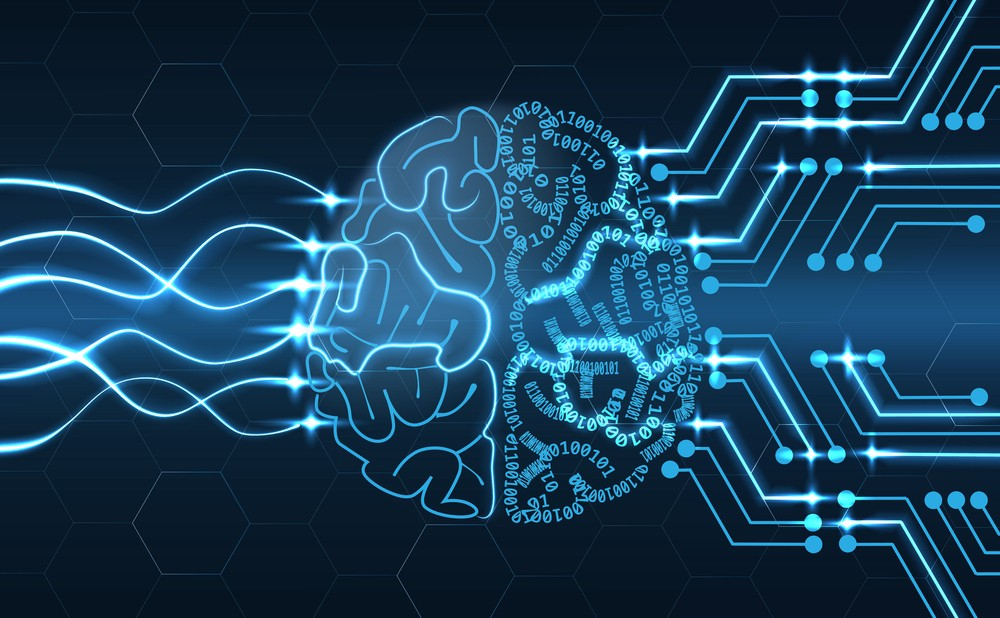

**Fashion MNIST** é um dataset padrão usado em Deep Learning e Computer Vision, contendo 70 mil imagens de 10 classes diferentes.

Apesar de trazer imagens já pré-processadas, representa um bom desafio para aplicar em redes neurais profundas. Serve também para demonstrar um tipo especial das redes neurais, as convolucionais (Convolutional Neural Networks - CNN).

O dataset é dividido entre treino (60 mil amostras) e teste (10 mil amostras), sendo que cada imagem possui dimensões de 28 x 28 pixels. Segue abaixo representação delas:

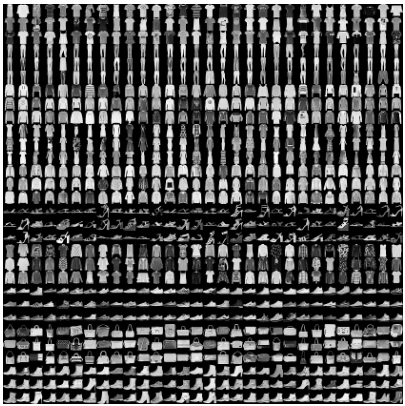

Cada imagem pertence a uma única classe na tabela abaixo segue a documentação do Fashion MNIST, onde são documentados os 10 labels (classes) possíveis:

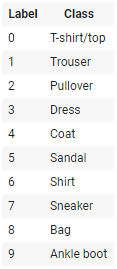

##Obtenção dos dados

Iremos obter os dados do Fashion MNIST carregando-o a partir do TensorFlow.

In [1]:
#Importar as bibliotecas necessárias
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import classification_report

#Melhorar a visualização de gráficos
%matplotlib inline
%config inlineBackend.figure_format = 'svg'
mpl.style.use("ggplot")
plt.style.use("fivethirtyeight")
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [2]:
#Carregar os dados do fashion MNIST
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Seguindo a padronização da documentação, iremos criar uma lista contendo os labels traduzidos para o portugês.

In [3]:
# De acordo com a documentação, os labels são:
class_names = ['Camisetas/Top', 'Calça', 'Suéter',
               'Vestidos','Casaco', 'Sandálias',
               'Camisas', 'Tênis', 'Bolsa', 'Botas']

## Exploração dos Dados

Apesar desse conjunto de dados vir previamente processado e bem documentado, vamos explora-lo rapidamente a fim de tirar alguns insights.

Primeiramente, vamos verificar as dimensões dos arrays retornados pela função fashion_mnist.load_data().

Há 60.000 amostras de treino e 10.000 de teste, sendo as imagens 28 x 28 pixels em tons de cinza (1 canal).

Também iremos ver como uma imagem "se parece" quando é convertida para um array. Vale lembrar que os valores de cada pixel estão compreendidos entre  [0,255] .

In [4]:
# ver a dimensionalidade dos DataFrames
print("Dimensionalidade dos DataFrames:")
print("X_train_orig:", X_train_orig.shape)
print("y_train_orig:", y_train_orig.shape)
print("X_test_orig:", X_test_orig.shape)
print("y_test_orig:", y_test_orig.shape)

# ver uma fatia de uma imagem
print("\n\nImagem convertida em array:\n", X_train_orig[0][:5][:5])

Dimensionalidade dos DataFrames:
X_train_orig: (60000, 28, 28)
y_train_orig: (60000,)
X_test_orig: (10000, 28, 28)
y_test_orig: (10000,)


Imagem convertida em array:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]]


Iremos verificar se os datasets de treino/teste estão balanceados.

In [5]:
# verificar os valores únicos por classes (treino)
print("y_train_orig:")
np.unique(y_train_orig, return_counts=True)

y_train_orig:


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [6]:
# verificar os valores únicos por classes (teste)
print("y_test_orig:")
np.unique(y_test_orig, return_counts=True)

y_test_orig:


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Há pouco a se explorar nesta análise exploratória preliminar, tratando-se mais de uma etapa visando aumentar a consciência situacional a respeito do dataset.

Vamos agora visualizar algumas imagens com seus labels (Classes).

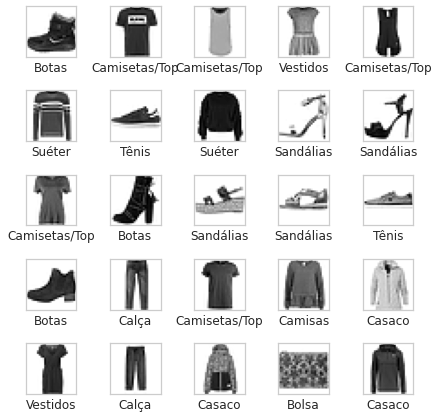

In [7]:
# Ver algumas imagens de exemplo
plt.figure(figsize=(6,6))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_orig[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_orig[i]])
plt.tight_layout()

## Pré-Processamento dos Dados

Antes de criar o modelo e treina-lo a rede neural, iremos passar por algumas etapas de pré-processamento.

### Normalizar os *pixels*

As intensidades dos *pixels* devem ser convertidos no tipo `float` e ficar dentro do intervalo $[0, 1]$.

Aqui, como o valor máximo do *pixel* é 255, então basta fazer a divisão de todos *pixels* individuais por 255.0 e eles estarão normalizados e do tipo `float`.

In [8]:
# criar função lambda que transforma em float32 e normaliza os pixels
f = lambda x: (x / 255.0).astype("float32")

# aplicar a função lambda aos datasets X_train e X_test
X_train = f(X_train_orig)
X_test = f(X_test_orig)

### Redimensionar as Imagens

O primeiro *layer* convolucional espera um único tensor que contenha todos os *pixels*. 

O TensorFlow espera uma única lista com 4 dimensões, e não 60000 itens de dimensões 28 x 28 x 1, como é o caso do *dataset* de treino e o mesmo vale para os dados de teste.

In [9]:
# redimensionar as imagens
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

print("X_train:{}".format(X_train.shape))
print("X_test:\t{}".format(X_test.shape))

X_train:(60000, 28, 28, 1)
X_test:	(10000, 28, 28, 1)


### One-Hot Encoding

Os *labels* já estão codificados entre 0 e 9, naquilo que chamamos de *Integer Encoding*. É possível utilizar diretamente o `y_train` e o`y_test`, desde que se use `loss="sparse_categorical_crossentropy"`.

No entanto, utilizá-los diretamente pode levar o modelo de *Deep Learning* a entender que há uma relação natural de ordem entre os *labels (Classes)*, o que não é verdade, podendo levar a um desempenho muito inferior.

Para variáveis categóricas onde não há nenhuma relação ordinal, então vamos usar o método One-Hot Encoding. Para saber mais sobre as diferenças entre essas duas técnicas, [leia este artigo](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

In [10]:
#One-Hot Encoding
y_train = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test_orig)

## Definindo uma Rede Neural Convolucional

Existem diversas arquiteturas consagradas de CNN, mas para este projeto, será utilizada uma arquitetura simplificada da VGGNet, implementada em um artigo do Cientista de Dados Adrian Rosebroke.

A implementação original foi adaptada a fim de adequar as dimensões 28 x 28 das nossas imagens e permitir o uso da API Keras.

In [11]:
# baseado na implementação da MiniVGGNet do Adrian Rosebroke
# first CONV => RELU => CONV => RELU => POOL layer set
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding="same", activation='relu',))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# softmax classifier
model.add(keras.layers.Dense(10, activation='softmax'))

Como mencionado anteriormente, uma vez que os labels estão one-hot encoded, iremos utilizar loss="categorical_crossentropy" para compilar o modelo.

Também será informado explicitamente o uso de dados de validação na proporção de 1/3.

In [14]:
#compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# treinar o modelo e salvar as informações em history
history = model.fit(X_train, y_train, epochs=20, validation_split=0.25)

Epoch 1/20
1407/1407 [==============================] - 11s 7ms/step - loss: 0.7123 - accuracy: 0.7627 - val_loss: 0.3872 - val_accuracy: 0.8633
Epoch 2/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.3493 - accuracy: 0.8750 - val_loss: 0.2723 - val_accuracy: 0.9033
Epoch 3/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2906 - accuracy: 0.8950 - val_loss: 0.2470 - val_accuracy: 0.9107
Epoch 4/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2673 - accuracy: 0.9043 - val_loss: 0.3333 - val_accuracy: 0.8848
Epoch 5/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2591 - accuracy: 0.9079 - val_loss: 0.2152 - val_accuracy: 0.9223
Epoch 6/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2337 - accuracy: 0.9152 - val_loss: 0.2061 - val_accuracy: 0.9237
Epoch 7/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2169 - accuracy: 0.9217 - val_loss: 0.2030 - val_accuracy

## Avaliando o Modelo

No geral, o nosso modelo atingiu uma acurácia de 95% nos dados de treino e 93% nos dados de validação.

No entanto, se observarmos melhor veremos que ela não teve o desempenho muito bom para a categoria "Camisas". 

Provavalmente isso pode ser melhorado com técnicas de *data augmentation*.

In [15]:
#avaliando o modelo
y_hat = model.predict(X_test)
y_hat_classes = np.argmax(y_hat, axis=1)
print(classification_report(y_test_orig, y_hat_classes, target_names=class_names))


               precision    recall  f1-score   support

Camisetas/Top       0.93      0.81      0.87      1000
        Calça       1.00      0.99      0.99      1000
       Suéter       0.87      0.94      0.90      1000
     Vestidos       0.95      0.91      0.93      1000
       Casaco       0.91      0.87      0.89      1000
    Sandálias       0.99      0.98      0.99      1000
      Camisas       0.75      0.85      0.79      1000
        Tênis       0.98      0.96      0.97      1000
        Bolsa       0.98      0.99      0.99      1000
        Botas       0.96      0.98      0.97      1000

     accuracy                           0.93     10000
    macro avg       0.93      0.93      0.93     10000
 weighted avg       0.93      0.93      0.93     10000



Vamos olhar as curvas accuracy e val_accuracy, podemos identificar talvez um pequeno overfitting, mas que não prejudicou muito o desempenho da CNN perante aos dados de validação.

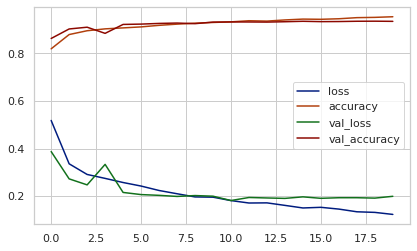

In [16]:
# plotar o histórico da otimização
pd.DataFrame(history.history).plot()
plt.show()

Vemos que a acurácia no dataset de teste se mantém muito boa, o que significa que o modelo é genérico o suficiente para lidar com dados novos.

In [18]:
score = model.evaluate(X_test, y_test)

# verificar o desempenho do modelo
print('Loss: {:.4f}'.format(score[0]))
print('Acurácia: {:.4f}'.format(score[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.2251 - accuracy: 0.9280
Loss: 0.2251
Acurácia: 0.9280
